In [1]:
import numpy as np
import trackpy as tp
import nplocate as nl
import matplotlib.pyplot as plt
import sys

%load_ext autoreload
%autoreload 2

# Anomaly Detection

When we finished the tracking, it is unavoidable that the final result will contain **terrible** tracking result.

I find it quite fruitful to implement the idea of anomaly detection from the machine learning society.

The idea is that, after tracking, we get a collection of coordinates, say $\{ \mathbf{r}_i \}$, we can calculate a lot of features from $\{ \mathbf{r}_i \}$, say $\{ \mathbf{f}_i \}$.

If we have a lot of $\{ \mathbf{f}_i \}$, it is expected that their joint probability distribution will be a multi-dimentional gaussian. So we can calculate the property of the PDF.

A normal particle found by the tracking, whose feature $\mathbf{f}_i$, will have a very low change shifting a lot from the centre of the gaussian PDF. If we denote the probability to $p_i$, then we can use a threshold $\epsilon$ to remove the features that $\mathbf{f}_i < \epsilon$

## Get tracking result.

In [2]:
img = np.load('image.npy')
img = nl.fix_intensity(img)
diameter = 11
xyz = tp.locate(img, diameter=diameter)
xyz = np.array(xyz)[:, :3]
xyz_tp = xyz.copy()
should_add = True
r_model = 2 * diameter
iter_num = 0
while should_add:
    n0 = xyz.shape[0]
    xyz = nl.add(
        positions=xyz,
        image=img,
        r_model=r_model,
        diameter=diameter,
        locate_func=lambda im : np.array(tp.locate(im, diameter))[:, :3],
        threshold=0
    )
    n1 = xyz.shape[0]
    should_add = n1 > n0
    iter_num += 1
xyz = nl.refine(xyz, img, r_model, diameter)

## Calculate some features


Now we calculate a lot of values to characterise the particle locations. The meaning of "characterising" is that we look at the voxel intensity distribution and calculate how it correlate with the spatial informations. 

For instance, if we weight the voxel intensity values around a particle by the distance between the voxels and the particle centre, we may get a somewhat uniform distribution. For each particle, we get this distribution. The feature of the distribution can be described by its mean, variance, skewness and kurtosis values.

For good particles centres, we expect their values to fall into a similar range, in a gaussian manner. Any point that is far away from the gaussian peak, shuold be considered as corresponding to a "bad" paritcle location. 

The above works a quite vague and difficult. Here we see an example. We first calculate the feature values,


In [3]:
pf = nl.ParticleFeatures(xyz, img, 10)

there are acturally <font color='teal'><big>36</big></font> features for each particle. These features are stored in a big numpy array whose shape is `(4, 9, particle_number)`.

These features are described as below.


```
   dr2 * intensity  ───────────────────┐
 dr2xy * intensity  ─────────────────┐ │
   dz2 * intensity  ───────────────┐ │ │
   dy2 * intensity  ─────────────┐ │ │ │
   dx2 * intensity  ───────────┐ │ │ │ │
    dz * intensity  ─────────┐ │ │ │ │ │
    dy * intensity  ───────┐ │ │ │ │ │ │
    dx * intensity  ─────┐ │ │ │ │ │ │ │
         intensity  ───┐ │ │ │ │ │ │ │ │
                    ┌─┬▼─▼─▼─▼─▼─▼─▼─▼─▼─┐
                    │ │0 1 2 3 4 5 6 7 8 │
                    ├─┼──────────────────┤
              mean  │0│f00    ....   f08 │
          variance  │1│        .         │
              skew  │2│         .        │
          kurtosis  │3│f30    ....   f38 │
                    └─┴──────────────────┘
```

Let's see how the following two features behave,

1. The average intensity (`features[0, 0]`)
2. The skewness of the z-position weighted intensity(`features[2, 3]`)

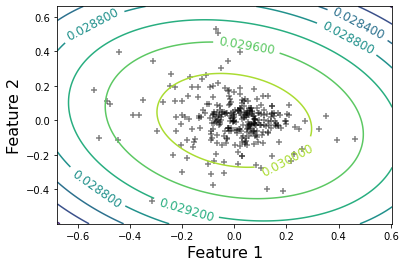

In [4]:
X = np.array((pf.features[0, 0], pf.features[2, 3]))
nl.feature_plot_2d(X)

The distribution looks quite like a 2D joint gaussian distribution. And you may think of getting rid of some particle some particles in the outter area. Here the contour shows the probability values from a gaussian fit. We can think of getting rid of particles, whose value is below 0.0296 for instance


But we only used 2 features in the above plot. Let's use all the 36 features! The result will be a 36-dimensional plot so we can't really visualise it. But we can calculate the probability value corresponding to each particles.

The following line shows the distribution of the probability values.

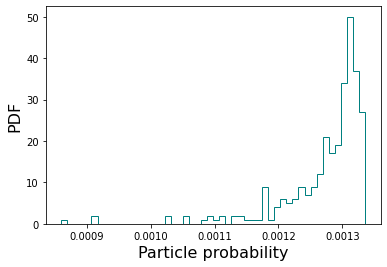

In [5]:
plt.hist(pf.prob, histtype='step', bins=50, color='teal')
plt.ylabel('PDF', fontsize=16)
plt.xlabel('Particle probability', fontsize=16)
plt.show()

Let's see the outlier

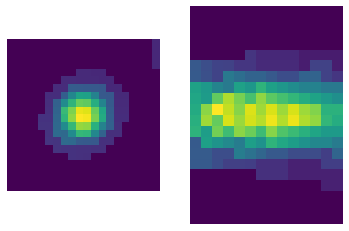

In [6]:
outlier = xyz[pf.prob < 0.001][0]
ox, oy, oz = outlier.ravel().astype(int)
plt.subplot(121).imshow(img[ox-10: ox+10, oy-10:oy+10, oz])
plt.axis('off')
plt.subplot(122).imshow(img[ox-10: ox+10, oy, oz-7:oz+7])
plt.axis('off')
plt.show()

It looks like there is only a half particle there, because the location is approaching the bottom.


The following images shows the pictures that are of high probabilities 

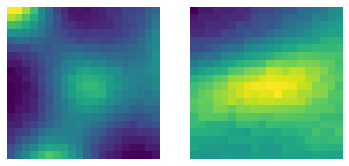

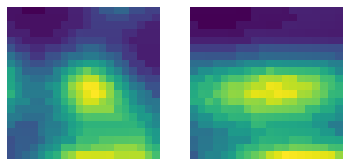

In [7]:
for outlier in xyz[pf.prob > 0.0012][50:52]:
    ox, oy, oz = outlier.ravel().astype(int)
    plt.subplot(121).imshow(img[ox-10: ox+10, oy-10:oy+10, oz])
    plt.axis('off')
    plt.subplot(122).imshow(img[ox-10: ox+10, oy, oz-10:oz+10])
    plt.axis('off')
    plt.show()

Let's caculate the g(r) before and after removing some outliers

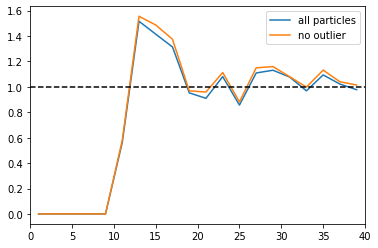

In [8]:
plt.plot(*nl.get_gr(xyz, 40, 21), label='all particles')
plt.plot(*nl.get_gr(xyz[pf.prob > 0.0011], 40, 21), label='no outlier')
plt.plot((0, 40), (1, 1), color='k', ls='--')
plt.xlim(0, 40)
plt.legend()
plt.show()